<a href="https://colab.research.google.com/github/ashia-002/Fake-News-Detection-Bilingual-Multimodel/blob/main/CNN_Pipeline/image_Clasification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

/tmp/ipython-input-2896494265.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## 1. Setting the path

In [4]:
# New line for Google Colab:
main_dir = r"/content/drive/MyDrive/CNN/data" # Adjust 'newsDataset' if you uploaded a different folder

In [5]:
import os
os.listdir(main_dir)

['fake', 'real']

In [6]:
for folder_name in os.listdir(main_dir):
    # 1. Get the full path to the subfolder ('/path/to/your/main_dir/fake')
    path_to_subfolder = os.path.join(main_dir, folder_name)

    # 2. Get the full path to the images ('/path/to/your/main_dir/fake/BN')
    for folder in os.listdir(path_to_subfolder):
      img_path = os.path.join(path_to_subfolder, folder)


In [7]:
#/content/drive/MyDrive/CNN/data/fake/BN/-1RWCMzPMOg.jpg
img = cv2.imread(os.path.join(main_dir, 'fake', 'BN', '-1RWCMzPMOg.jpg'))

In [8]:
type(img) #numpy array


numpy.ndarray

In [9]:
img.shape #rgb channel

(720, 1280, 3)

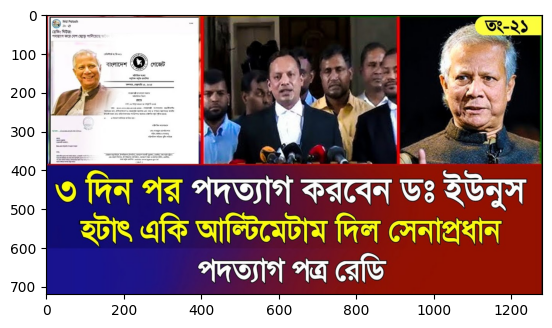

In [10]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 2. loading Image

In [11]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [12]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

### 2.1. removing empty image

In [13]:
for folder_name in os.listdir(main_dir):
    # 1. Get the full path to the subfolder ('/path/to/your/main_dir/fake')
    path_to_subfolder = os.path.join(main_dir, folder_name)

    # 2. Get the full path to the images ('/path/to/your/main_dir/fake/BN')
    for folder in os.listdir(path_to_subfolder):
      img_path = os.path.join(path_to_subfolder, folder)

      try:
        img = cv2.imread(img_path)
        tip = imghdr.what(img_path)
        if tip not in image_exts:
          print('Image not in ext list{}'.format(img_path))
          os.remove(img_path)
      except Exception as e:
        print('Issue with image {}'.format(img_path))



Issue with image /content/drive/MyDrive/CNN/data/fake/EN
Issue with image /content/drive/MyDrive/CNN/data/fake/BN
Issue with image /content/drive/MyDrive/CNN/data/real/EN
Issue with image /content/drive/MyDrive/CNN/data/real/BN


### 2.2. load data in tensorflow

In [14]:
import tensorflow as tf

In [15]:
# for building data pipeline
tf.data.Dataset??

In [16]:
tf.keras.utils.image_dataset_from_directory??

In [17]:
data = tf.keras.utils.image_dataset_from_directory(main_dir)

Found 4000 files belonging to 2 classes.


In [18]:
'''A Python iterator allows you to use standard Python flow control,
primarily the next() function or a for loop, to sequentially pull data batches.'''
data_iterator = data.as_numpy_iterator() #allowing to loop through the whole pipelne

In [19]:
batch = data_iterator.next() # grabing the batch each time

In [20]:
len(batch) # two parts: image from the directory(batch[0]), label(batch[1])

2

In [21]:
# represented as numpy arrays
batch[0].shape #the pipeline automatically reshaped the image

(32, 256, 256, 3)

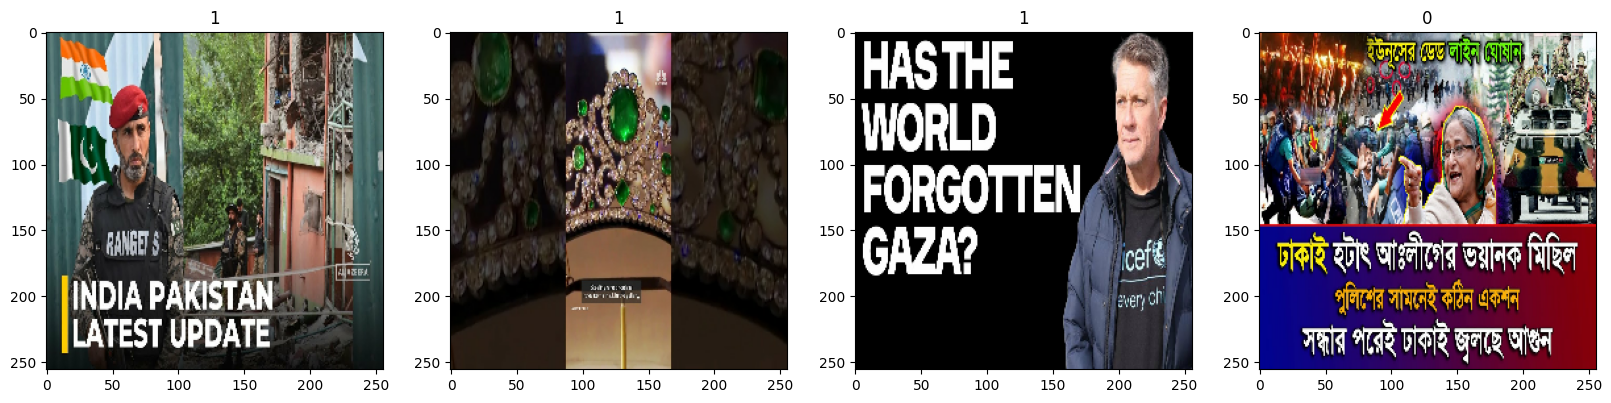

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx]) #fake = 0, real = 1

## 3. Preprocess data

In [23]:
batch[0].max()

np.float32(255.0)

In [24]:
batch[0].min()

np.float32(0.0)

### 3.1. Normalization$\text{Value} / 255$

In [25]:
data = data.map(lambda x,y: (x/255, y)) #in pipeline mapping each batch and normalizing where x=batch[0]

In [26]:
# now looking at a batch
batch = data.as_numpy_iterator().next()

In [27]:
batch[0].min()

np.float32(0.0)

In [28]:
batch[0].max()

np.float32(1.0)

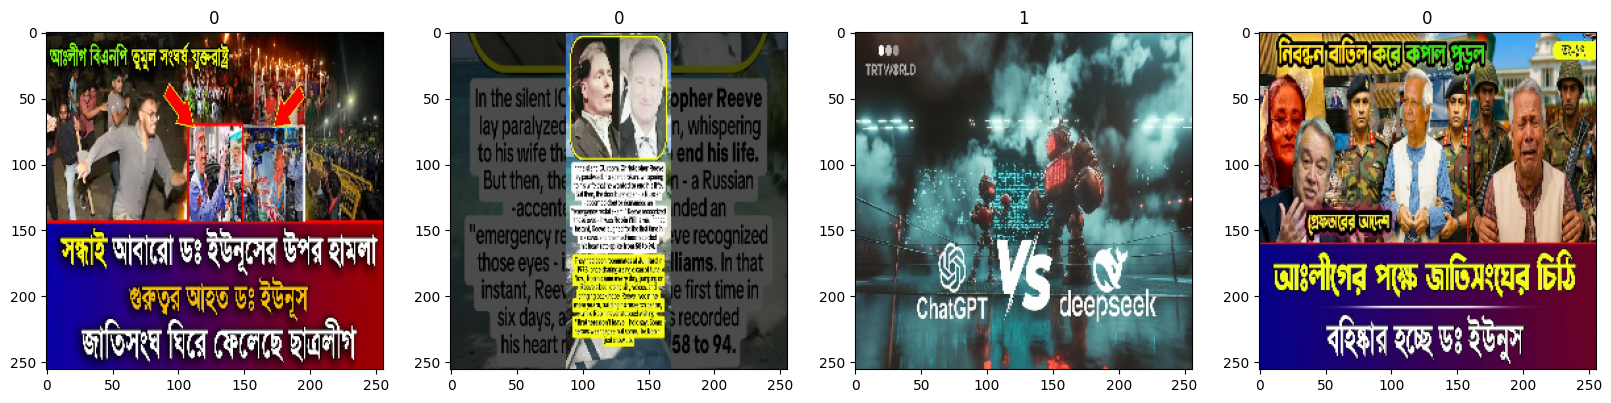

In [29]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(float)) #now it's not int anymore
  ax[idx].title.set_text(batch[1][idx]) #fake = 0, real = 1

### 3.2. Split the data

In [30]:
len(data) # total 125 batches(125x32=4000)

125

In [31]:
# Calculate 70% of the total number of batches/elements in the dataset for training.
train_size = int(len(data) * 0.7)
# Calculate 20% for validation, and add 1 to ensure all data is accounted for when using integer math.
val_size = int(len(data) * 0.2) + 1
# Calculate 10% for testing, and add 1 to ensure all data is accounted for when using integer math.
test_size = int(len(data) * 0.1) + 1

In [32]:
val_size

26

In [33]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [34]:
#Final Optimization (Cache and Prefetch) ---
AUTOTUNE = tf.data.AUTOTUNE
# Shuffle the ENTIRE Dataset FIRST ---
# This ensures a random distribution across the resulting splits.
BUFFER_SIZE = 1000  # A good buffer size for effective shuffling
data = data.shuffle(buffer_size=BUFFER_SIZE)

In [35]:
# Apply cache and prefetch to ALL datasets
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

print("Data pipeline successfully implemented:")
print(f"   - Full dataset was shuffled before splitting.")
print(f"   - Split sizes: Train ({train_size}), Val ({val_size}), Test ({len(test)})")
print(f"   - All datasets are optimized with .cache() and .prefetch().")

Data pipeline successfully implemented:
   - Full dataset was shuffled before splitting.
   - Split sizes: Train (87), Val (26), Test (12)
   - All datasets are optimized with .cache() and .prefetch().


## 4. Build Model

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

In [37]:
model = Sequential()

In [38]:
# Block 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Block 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Block 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# --- Classification Head ---

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,467,073 (28.48 MB)

 Trainable params: 7,466,625 (28.48 MB)

 Non-trainable params: 448 (1.75 KB)

### 4.1 Train the model

In [41]:
log_dir = r"/content/drive/MyDrive/CNN/logs"

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [43]:
# Setup Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',         # Stop when validation loss stops improving
    patience=8,                # Wait 8 epochs for improvement
    restore_best_weights=True   # Keep the best weights found
)

In [44]:
hist = model.fit(train,
                 epochs=20,
                 validation_data=val,
                 callbacks=[tensorboard_callback, early_stopping] )

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 875s 10s/step - accuracy: 0.8465 - loss: 3.4942 - val_accuracy: 0.4880 - val_loss: 28.6712
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 679s 8s/step - accuracy: 0.9181 - loss: 0.6948 - val_accuracy: 0.7308 - val_loss: 2.5099
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 681s 8s/step - accuracy: 0.9325 - loss: 0.2476 - val_accuracy: 0.5493 - val_loss: 9.3342
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 682s 8s/step - accuracy: 0.9266 - loss: 0.2369 - val_accuracy: 0.8930 - val_loss: 1.1427
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 734s 8s/step - accuracy: 0.9495 - loss: 0.1703 - val_accuracy: 0.8954 - val_loss: 0.7478
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 682s 8s/step - accuracy: 0.9655 - loss: 0.1426 - val_accuracy: 0.9399 - val_loss: 0.5236
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 688s 8s/step - accuracy: 0.9616 - loss: 0.1507 - val_accuracy: 0.9579 - val_loss: 0.4621
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 678s 8s/step - accuracy: 0.9674 - loss: 0.1289 - val_accuracy: 0.9772 -

### 4.2. Plot Performance

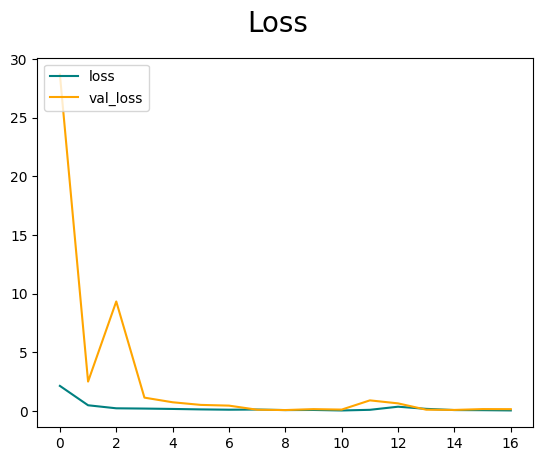

In [45]:
fig = plt.figure(figsize=(6,4))
plt.plot(hist.history['loss'], color='teal', label='Training Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Model Loss Over Epochs', fontsize=18)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### 4.3. Evaluate the model

In [47]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [48]:
y_true = []
y_pred = []
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)

    # Update TensorFlow metrics
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

    # Convert predictions to binary (0/1)
    yhat_bin = np.round(yhat).astype(int)

    # Append for sklearn metrics
    y_true.extend(y)
    y_pred.extend(yhat_bin)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [53]:
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Compute F1-score and confusion matrix
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Print results
print("\n--- Evaluation Metrics ---")
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")
print(f"F1 Score: {f1:.4f}")

# Evaluate model using built-in method for comparison
print("\n--- TensorFlow Model Evaluate ---")
test_results = model.evaluate(test)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]*100:.2f}%")



--- Evaluation Metrics ---
Precision: 0.9781
Recall: 0.9728
Accuracy: 0.9766
F1 Score: 0.9755

--- TensorFlow Model Evaluate ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9909 - loss: 0.0455
Test Loss: 0.1071
Test Accuracy: 97.66%


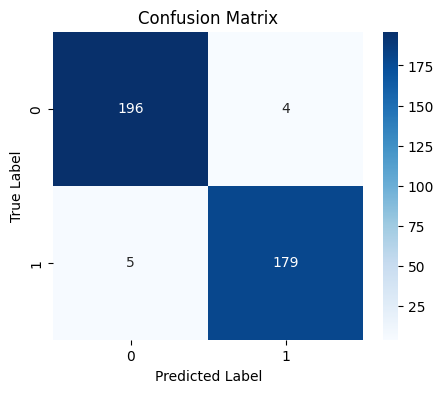

In [64]:
# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 5. Test Model

Saving fake01.jpg to fake01 (1).jpg
Saving fake02.jpg to fake02 (1).jpg
Saving fake03.jpg to fake03 (1).jpg
Saving fake04.jpg to fake04 (1).jpg
Saving fake05.jpg to fake05 (1).jpg
Saving fake06.jpg to fake06 (1).jpg
Saving fake07.jpg to fake07 (1).jpg
Saving fake08.jpg to fake08 (1).jpg
Saving fake09.jpg to fake09 (1).jpg
Saving fake10.jpg to fake10 (1).jpg
Saving real01.jpg to real01 (1).jpg
Saving real02.jpg to real02 (1).jpg
Saving real03.jpg to real03 (1).jpg
Saving real04.jpg to real04 (1).jpg
Saving real05.jpg to real05 (1).jpg
Saving real06.jpg to real06 (1).jpg
Saving real07.jpg to real07 (1).jpg
Saving real08.jpg to real08 (1).jpg
Saving real09.jpg to real09 (1).jpg
Saving real10.jpg to real10 (1).jpg


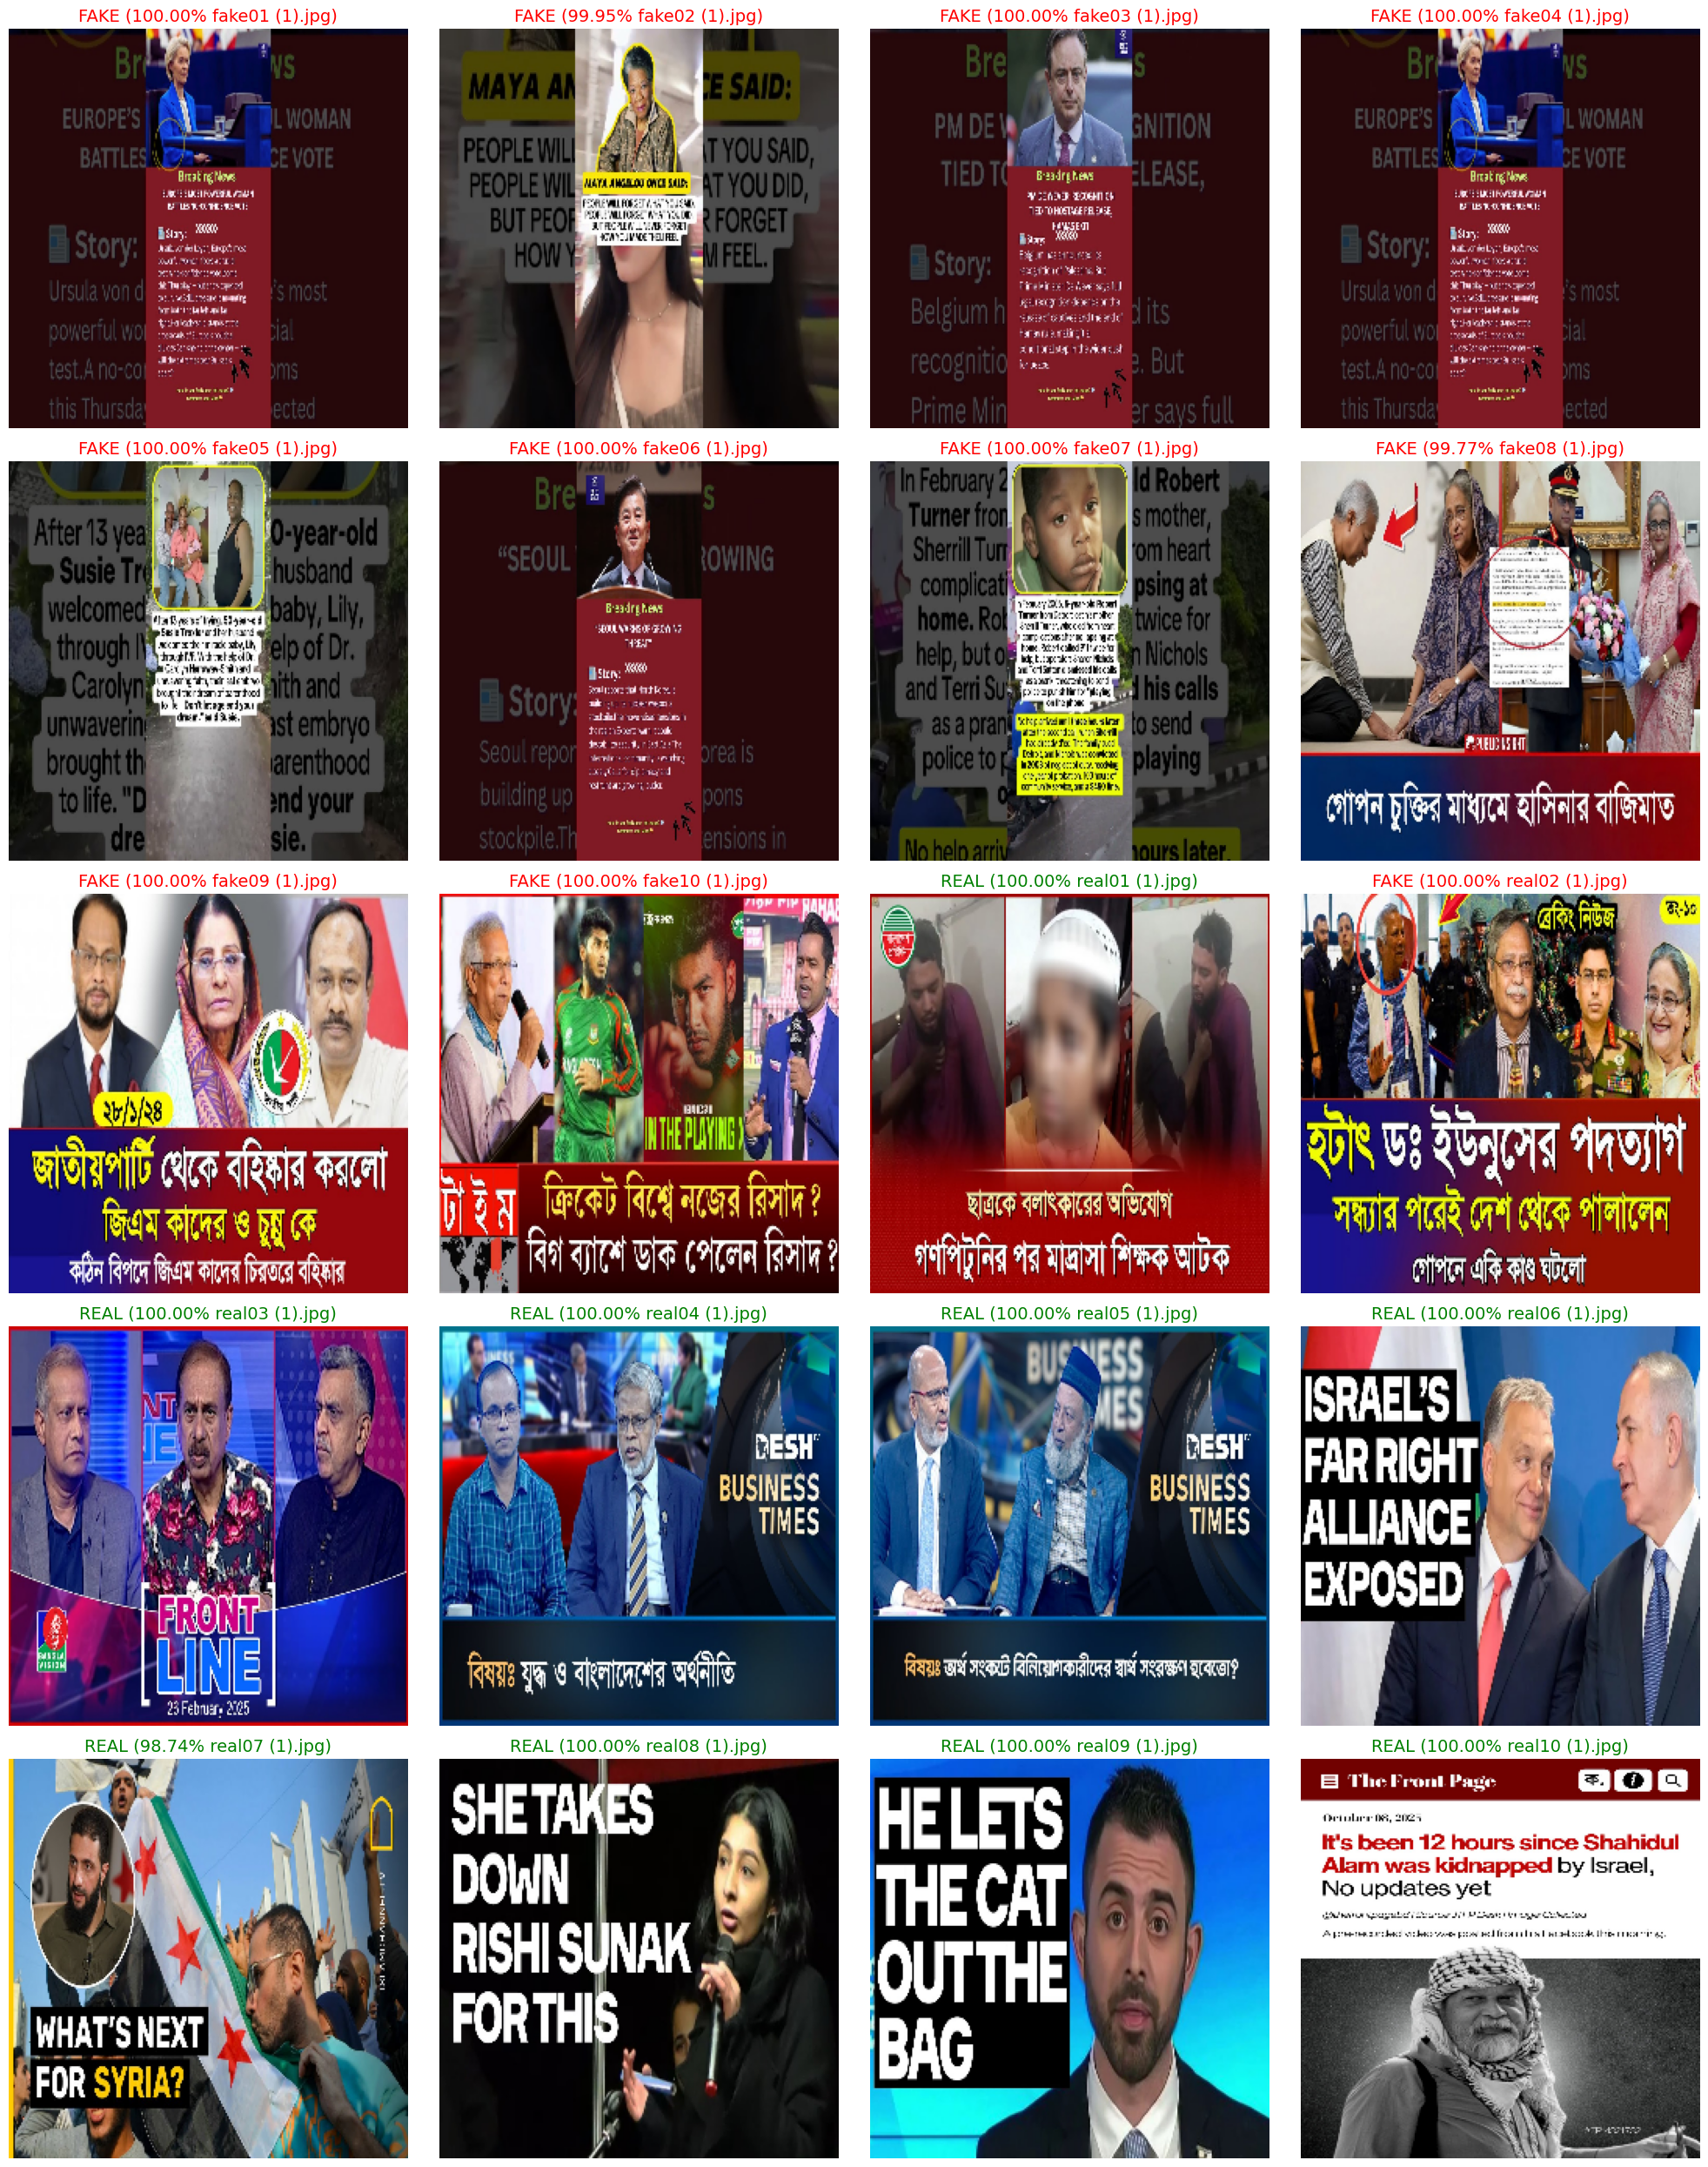

In [58]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from google.colab import files

# --- 1. Upload Files ---
uploaded = files.upload()

IMAGE_SIZE = (256, 256)
NUM_COLS = 4
num_images = len(uploaded)
# Calculate the number of rows needed for the 4-column layout
NUM_ROWS = (num_images + NUM_COLS - 1) // NUM_COLS

# Create the figure for the grid of subplots
fig, ax = plt.subplots(ncols=NUM_COLS, nrows=NUM_ROWS, figsize=(5 * NUM_COLS, 5 * NUM_ROWS))
i = 0 # Initialize a counter for flat indexing (0 to num_images - 1)

# Ensure 'ax' is a 1D array for simpler indexing, even if NUM_ROWS is 1
ax_flat = ax.flatten() if isinstance(ax, np.ndarray) else np.array([ax])

# Iterate through every filename uploaded
for filename in uploaded.keys():

    # 2. Load and Convert Image (BGR -> RGB)
    img_bgr = cv2.imread(filename)

    if img_bgr is None:
        print(f"Error: Could not load image file '{filename}'. Skipping.")
        continue

    rgb_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 3. Preprocess for Model Prediction
    resize_tensor = tf.image.resize(rgb_img, IMAGE_SIZE)
    img_array = resize_tensor.numpy()

    # Normalize and add batch dimension
    input_tensor = img_array.astype(np.float32) / 255.0
    input_tensor = tf.expand_dims(input_tensor, 0)

    # 4. Make the Prediction
    prediction = model.predict(input_tensor, verbose=0) # Set verbose=0 to silence output
    probability = prediction[0][0]

    # 5. Interpret the Result
    if probability > 0.5:
        result = "REAL"
        confidence = probability * 100
        color = 'green'
    else:
        result = "FAKE"
        confidence = (1 - probability) * 100
        color = 'red'

    # 6. Display in Subplot with Prediction Title

    # Use the flattened axis array for indexing
    current_ax = ax_flat[i]

    # Plot the image
    current_ax.imshow(img_array.astype('uint8'))

    # Create the title with prediction and confidence
    title_text = f"{result} ({confidence:.2f}% {filename})"
    current_ax.set_title(title_text, fontsize=14, color=color)
    current_ax.axis('off') # Hide axes

    # print(f"Model Prediction: **{result}** (Confidence: {confidence:.2f}%)")
    i += 1

# Hide any empty subplots in the last row if the total number of images wasn't a multiple of 4
for j in range(i, len(ax_flat)):
    ax_flat[j].axis('off')

plt.tight_layout()
plt.show()

## 6. Save the Model

In [59]:
from tensorflow.keras.models import load_model

In [66]:
model.save(os.path.join('/content/drive/MyDrive/CNN/models', 'fake_news_classification_CNN.keras'))

In [67]:
my_model = load_model(os.path.join('/content/drive/MyDrive/CNN/models', 'fake_news_classification_CNN.keras'))

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [68]:
my_model

<Sequential name=sequential, built=True>